<a href="https://colab.research.google.com/github/emivlp/Pyspark_SparkSQL/blob/main/pyspark_housing_analysis_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PySpark Housing Data Analysis & ML Pipeline**

PySpark is the Python interface for Apache Spark, and its primary use cases include working with huge amounts of data and creating efficient data pipelines. While you don't necessarily need big data to benefit from PySpark, its SparkSQL functionality can significantly simplify routine data analysis—especially when compared to traditional Pandas workflows, which can become cumbersome for data cleaning and transformation tasks.

This notebook presents a professional, end-to-end workflow for the **California Housing dataset**. This dataset provides key information about housing features across various **districts** in California, including:

- **Geographic Features**: longitude, latitude
- **Housing Characteristics**: housing_median_age, total_rooms, total_bedrooms, households
- **Demographic & Economic Features**: population, median_income, median_house_value

In this notebook, our goals are to:

- **Perform Exploratory Data Analysis (EDA)**:
 Inspect the dataset by examining its schema, descriptive statistics, missing - data, distinct values, and performing various aggregations.

- **Visualize Data**:
Convert small subsets of the data to Pandas DataFrames to create visualizations (e.g., bar charts, heatmaps, histograms, and boxplots) that reveal underlying trends and correlations.

- **Engineer Features**:
Enhance the dataset by creating new, informative features. Examples include ratios (such as rooms per household), logarithmic transformations to reduce skewness, categorical binning (e.g., age categories), and interaction terms.

- **Build Machine Learning Pipelines**:
Develop regression models—including Linear Regression, Random Forest, and Gradient Boosted Trees—using Spark ML. The pipelines incorporate steps such as categorical indexing, feature vector assembly, model training, and evaluation.

- **Hyperparameter Tuning**:
Use CrossValidator with grid search to optimize Random Forest model parameters (e.g., number of trees and maximum depth).

- **Model Evaluation**:
Assess model performance using RMSE and R² metrics and visualize predictions against actual values.

# **Development Overview**

## **1. Environment Setup and Data Loading**
- **Installation and Configuration:**  
  The notebook begins by updating packages, installing Java 8 (required for Spark), downloading Spark 3.2.1, and installing Python libraries such as `findspark`, `pyspark`, and `py4j`.  
  *Comments* explain the purpose of each step.
- **SparkSession Creation:**  
  A SparkSession is created, which serves as the entry point for interacting with Spark.
- **Data Loading:**  
  The California Housing CSV file is loaded into a PySpark DataFrame with header information and schema inference.

In [1]:
# 1. Update packages
!sudo apt update

# 2. Install Java 8 (required by Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 3. Download and extract Spark 3.2.1 (this link can change depending on Spark versions)
# NOTE: If the .tgz link is not found or out of date, visit https://spark.apache.org/downloads.html
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# 4. Install findspark and PySpark
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
import findspark
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

findspark.init()
print(f"findspark location: {findspark.find()}")

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

# Create our SparkSession
spark = (
    SparkSession.builder
    .appName("PySpark_Housing_Analysis")
    .getOrCreate()
)

spark


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
25 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

### **Loading the Data**
- Loading the California Housing dataset from a CSV file.  Assumes the file is in the Colab 'sample_data' directory. Adjust if your file is located elsewhere.



In [2]:
import requests

# Path to the sample data in Google Colab
data_path = "/content/sample_data/california_housing_train.csv"

# Load CSV into PySpark DataFrame
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show the first few rows
df.show(5)


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
+---------+--------+----

## **2. Data Inspection and EDA**
- **Schema and Statistics:**  
  The schema is printed to verify correct data types, and descriptive statistics are generated using `.describe()` to understand variable distributions.
- **Row Count and Sample Display:**  
  The total number of rows is confirmed, and selected columns (e.g., `housing_median_age` and `total_rooms`) are displayed to get a quick overview.
- **Missing Data Check:**  
  A check is performed to ensure that there are no missing values, simplifying further processing.
- **Aggregations and Grouping:**  
  Various aggregation queries (grouping by `housing_median_age` and calculating sums and averages) are executed to derive insights.
- **Income Range Statistics:**  
  Income ranges are created for `median_income` (low, medium, high), and aggregated statistics (mean house value, counts) are calculated.

In [3]:
# Displaying the schema to understand data types.
df.printSchema()


root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [4]:
# Showing summary statistics for numerical columns.
df.describe().show()


+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|          longitude|          latitude|housing_median_age|      total_rooms|   total_bedrooms|        population|       households|     median_income|median_house_value|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              17000|             17000|             17000|            17000|            17000|             17000|            17000|             17000|             17000|
|   mean|-119.56210823529375|  35.6252247058827| 28.58935294117647|2643.664411764706|539.4108235294118|1429.5739411764705|501.2219411764706| 3.883578100000021|207300.91235294117|
| stddev| 2.0051664084260357|2.1373397946570867|12.586936981660406|2179.947071452777|421.4994515798648| 1

In [5]:
# Checking the number of rows in the dataset.
num_rows = df.count()
print("Number of rows:", num_rows)


Number of rows: 17000


In [6]:
# Displaying a few rows with selected columns.
df.select("housing_median_age", "total_rooms").show(5)


+------------------+-----------+
|housing_median_age|total_rooms|
+------------------+-----------+
|              15.0|     5612.0|
|              19.0|     7650.0|
|              17.0|      720.0|
|              14.0|     1501.0|
|              20.0|     1454.0|
+------------------+-----------+
only showing top 5 rows



#### **Missing Data Check**

It’s often crucial to see how many null values we have in each column.

- If any column had missing values, you’d see a non-zero count for that column.
- In this dataset, it appears there are 0 nulls for all columns, which simplifies cleaning.

In [7]:
# Checking for missing values in each column.
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



## **3 Exploratory Data Analysis (EDA)**
#### **3.1. Distinct Values**

Sometimes you want to see how many unique values are in a column, for instance `total_rooms.`


In [8]:
# Counting distinct values in 'total_rooms'.
distinct_rooms = df.select("total_rooms").distinct()
print("Distinct total_rooms count:", distinct_rooms.count())


Distinct total_rooms count: 5533


### **3.2. Grouping & Aggregations**

Let’s do an example grouping by `housing_median_age`, summing over `total_rooms`.
- This can reveal how total rooms distribute across different housing ages.


In [9]:
# Grouping by 'housing_median_age' and summing 'total_rooms'.
df_grouped = (
    df.groupBy("housing_median_age")
      .agg(F.sum("total_rooms").alias("sum_rooms"))
      .orderBy("housing_median_age")
)

df_grouped.show(10)

+------------------+---------+
|housing_median_age|sum_rooms|
+------------------+---------+
|               1.0|   4316.0|
|               2.0| 256618.0|
|               3.0| 318335.0|
|               4.0| 976564.0|
|               5.0| 980326.0|
|               6.0| 563093.0|
|               7.0| 856609.0|
|               8.0| 725668.0|
|               9.0| 655916.0|
|              10.0| 795177.0|
+------------------+---------+
only showing top 10 rows



### **3.3. Combining Aggregations**
We can compute multiple statistics at once:
- This yields a quick look at how **housing age** correlates with median **house value and income**.



In [10]:
from pyspark.sql import functions as F

# Calculating multiple statistics by 'housing_median_age'.
df_stats = (
    df.groupBy("housing_median_age")
      .agg(
          F.mean("median_house_value").alias("avg_median_value"),
          F.mean("median_income").alias("avg_income"),
          F.count("*").alias("count_rows")
      )
      .orderBy(F.desc("avg_median_value"))
)

df_stats.show(10, truncate=False)


+------------------+------------------+------------------+----------+
|housing_median_age|avg_median_value  |avg_income        |count_rows|
+------------------+------------------+------------------+----------+
|52.0              |277368.2005703422 |3.943036787072241 |1052      |
|51.0              |244850.125        |3.6705031249999998|32        |
|3.0               |239450.04347826086|5.57201304347826  |46        |
|4.0               |230054.1055900621 |5.196055279503106 |161       |
|2.0               |229438.83673469388|5.074236734693878 |49        |
|48.0              |224665.25185185185|3.5262607407407405|135       |
|45.0              |223464.74468085106|3.739467234042551 |235       |
|25.0              |223097.2234273319 |4.1358900216919725|461       |
|50.0              |222513.48214285713|3.4723723214285713|112       |
|49.0              |220667.6126126126 |3.5476567567567545|111       |
+------------------+------------------+------------------+----------+
only showing top 10 

### **3.4. Statistics by Income Range**
We create ranges for median_income and display statistics for each range.

In [11]:
# Creating income ranges and calculating statistics for each range.
df_income = df.withColumn("income_range",
                          F.when(F.col("median_income") < 3, "low")
                           .when((F.col("median_income") >= 3) & (F.col("median_income") < 6), "medium")
                           .otherwise("high"))
df_income.groupBy("income_range").agg(
    F.mean("median_house_value").alias("avg_house_value"),
    F.count("*").alias("count")
).orderBy("income_range").show()


+------------+------------------+-----+
|income_range|   avg_house_value|count|
+------------+------------------+-----+
|        high| 379917.6130982368| 1985|
|         low| 133297.1103208733| 6046|
|      medium|218983.69037796857| 8969|
+------------+------------------+-----+



## **4. Data Visualization**
- **Conversion to Pandas:**  
  Since PySpark does not provide built-in visualization tools, small DataFrames are converted to Pandas DataFrames.
- **Visualizations:**  
  Bar charts, heatmaps, histograms, and boxplots are generated using `matplotlib` and `seaborn` to illustrate the relationships among variables.

In [12]:
# Converting PySpark DataFrames to Pandas for plotting.
pdf_grouped = df_grouped.toPandas()  # Small DataFrame is safe to convert
pdf_grouped.head(5)


,housing_median_age,sum_rooms
0,1.0,4316.0
1,2.0,256618.0
2,3.0,318335.0
3,4.0,976564.0
4,5.0,980326.0


### **Bar Chart: Total Rooms vs. Housing Median Age**

Let’s create a bar chart of `housing_median_age` vs. `sum_rooms` (the total number of rooms).

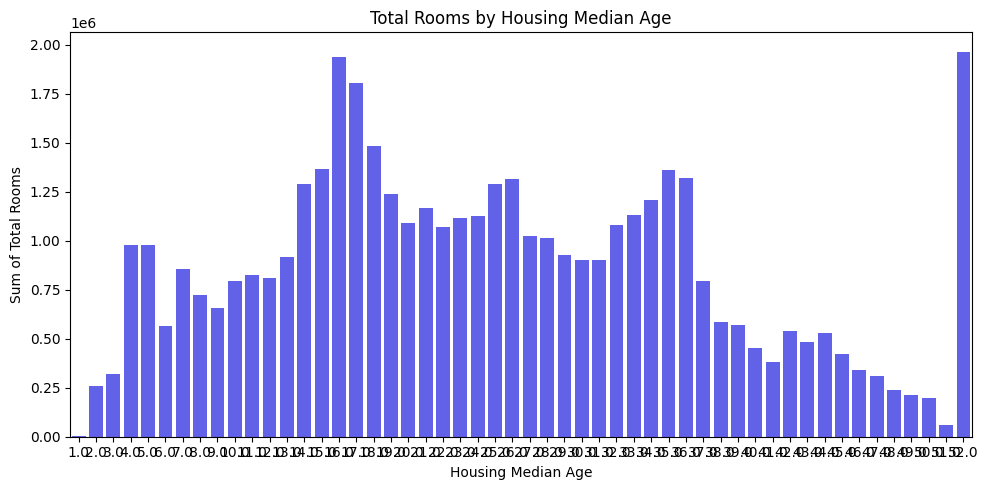

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## We'll do a simple plot using our df_grouped from earlier
#df_rooms_age = (
#    df.groupBy("housing_median_age")
#      .agg(F.sum("total_rooms").alias("sum_rooms"))
#      .orderBy("housing_median_age")
#)

pdf_rooms_age = df_grouped.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="housing_median_age", y="sum_rooms", data=pdf_rooms_age, color='blue', alpha=0.7)
plt.title("Total Rooms by Housing Median Age")
plt.xlabel("Housing Median Age")
plt.ylabel("Sum of Total Rooms")
plt.tight_layout()
plt.show()

## **Further Exploration**

### **Correlation Analysis**

We can check correlations between numeric columns like `median_income`, `median_house_value`, `total_rooms`, etc., similar to:

- This helps detect any linear relationships among the variables (e.g., median_income often has a moderate to strong positive correlation with median_house_value).

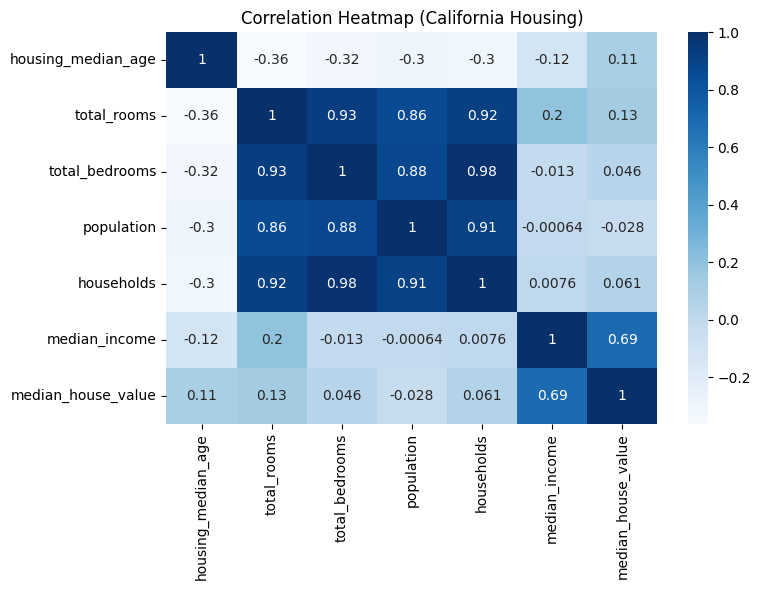

In [14]:
# Calculating and visualizing the correlation matrix.

df_corr = df.select(
    "housing_median_age", "total_rooms", "total_bedrooms", "population",
    "households", "median_income", "median_house_value"
)

pdf_corr = df_corr.toPandas()
corr_matrix = pdf_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Correlation Heatmap (California Housing)")
plt.tight_layout()
plt.show()


### **Distribution / Histogram**
- We can quickly visualize the distribution of median_house_value:

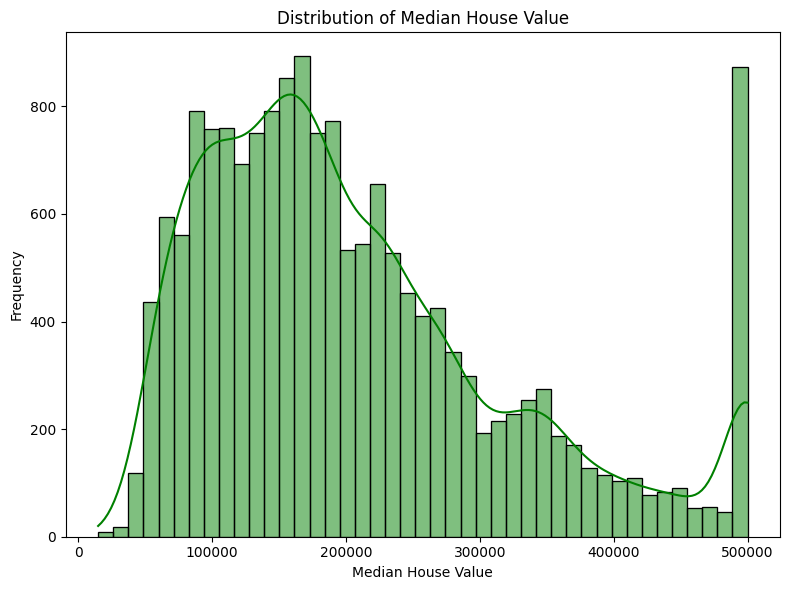

In [15]:
# Visualizing the distribution using a histogram.

plt.figure(figsize=(8,6))
sns.histplot(pdf_corr["median_house_value"], kde=True, color='green')
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### **BoxPlot: Income Comparison by Age Ranges**
- We convert grouped data and display a boxplot to detect outliers.


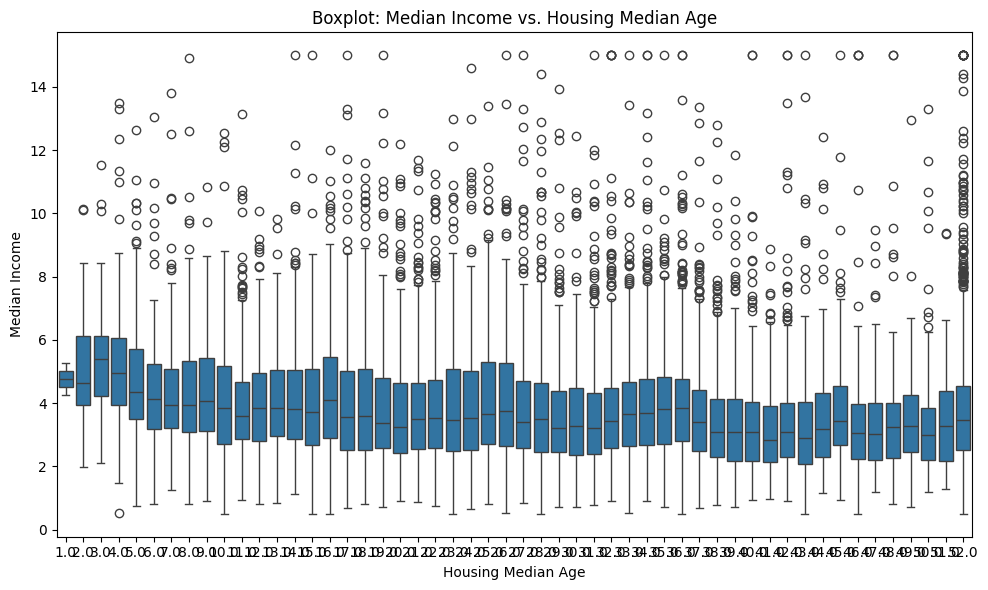

In [16]:
# Comparing income distribution across age ranges using boxplots.

pdf_box = df.select("housing_median_age", "median_income").toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x="housing_median_age", y="median_income", data=pdf_box)
plt.title("Boxplot: Median Income vs. Housing Median Age")
plt.xlabel("Housing Median Age")
plt.ylabel("Median Income")
plt.tight_layout()
plt.show()

# **Conclusion**

- Data Quality: We discovered that this dataset has no missing values—a rarity in real-world data.
- Aggregations: We showcased grouping and aggregation queries to derive insights.
- Visualization: Since PySpark lacks native visualization, we converted selected subsets to Pandas and used matplotlib/seaborn for basic plots.

These techniques form a core workflow in PySpark data exploration: reading data, inspecting schema, handling missing values, performing aggregations, and visualizing final results. For large-scale data, this approach scales effectively in Spark, while still leveraging Python’s robust plotting libraries when converting smaller subsets to Pandas.



---



---



---



---



---



---




# **5. Advanced Feature Engineering**

- **New Feature Creation:**  
  Additional features such as ratios (rooms per household, bedrooms per room), logarithmic transformations, and interaction terms (e.g., `age_income_interaction`) are created.
- **Categorization:**  
  The housing median age is categorized into bins (e.g., young, mid-age, old) to capture non-linear effects.
- **Polynomial Features:**  
  Further enhancements include creating a squared term for `median_income` and an interaction term between `log_total_rooms` and `population`.


In [17]:
from pyspark.sql.functions import log, col, when

# Creating new features to potentially improve model performance.

# Creating new features to potentially improve model performance.

df_fe = df.withColumn("rooms_per_household", F.col("total_rooms") / F.col("households"))
df_fe = df_fe.withColumn("bedrooms_per_room", F.col("total_bedrooms") / F.col("total_rooms"))
df_fe = df_fe.withColumn("population_per_household", F.col("population") / F.col("households"))

df_fe = df_fe.withColumn("age_category",
        F.when(F.col("housing_median_age") < 20, "young")
  .when((F.col("housing_median_age") >= 20) & (F.col("housing_median_age") < 40), "mid-age")
  .otherwise("old"))

df_fe = df_fe.withColumn("log_total_rooms", F.log(F.col("total_rooms") + 1))
df_fe = df_fe.withColumn("log_total_bedrooms", F.log(F.col("total_bedrooms") + 1))
df_fe = df_fe.withColumn("log_population", F.log(F.col("population") + 1))
df_fe = df_fe.withColumn("age_income_interaction", F.col("housing_median_age") * F.col("median_income"))

df_fe.select("total_rooms", "households", "rooms_per_household", "bedrooms_per_room",
            "population_per_household", "age_category", "log_total_rooms", "age_income_interaction").show(5)

+-----------+----------+-------------------+-------------------+------------------------+------------+-----------------+----------------------+
|total_rooms|households|rooms_per_household|  bedrooms_per_room|population_per_household|age_category|  log_total_rooms|age_income_interaction|
+-----------+----------+-------------------+-------------------+------------------------+------------+-----------------+----------------------+
|     5612.0|     472.0| 11.889830508474576|0.22861724875267284|      2.1504237288135593|       young|  8.6328406149422|                22.404|
|     7650.0|     463.0|  16.52267818574514|0.24849673202614378|      2.4384449244060473|       young|8.942591637231851|                 34.58|
|      720.0|     117.0|  6.153846153846154|0.24166666666666667|      2.8461538461538463|       young|6.580639137284949|               28.0653|
|     1501.0|     226.0| 6.6415929203539825|0.22451698867421718|      2.2787610619469025|       young| 7.31455283232408|               4

# **6. Building ML Pipelines and Model Training**

- **Pipeline Construction:**  
  Using Spark ML, pipelines are built for three models:
  - **Linear Regression:** Provides a baseline linear model.
  - **Random Forest:** Captures non-linearities and interactions effectively.
  - **Gradient Boosted Trees (GBT):** Further improves predictions by sequentially correcting errors.
- **Data Splitting:**  
  The dataset is split into training (80%) and testing (20%) sets.
- **Model Evaluation:**  
  Each model is evaluated using RMSE and R² metrics.

### **Importing PySpark ML Libraries**

In [18]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

### **6.1. Data Preparation**
Select the features and the label:

In [19]:
# Rename the target column to 'label'
df_fe = df_fe.withColumnRenamed("median_house_value", "label")

# Index the categorical variable "age_category"
age_indexer = StringIndexer(inputCol="age_category", outputCol="age_category_index")


### **6.2. Feature Engineering Enhancements**

In [20]:
# 9.2. Feature Engineering Enhancements
# Create polynomial features (example: squared median_income)
df_fe = df_fe.withColumn("median_income_squared", pow(F.col("median_income"), 2))

# Create interaction term
df_fe = df_fe.withColumn("log_total_rooms_population", F.col("log_total_rooms") * F.col("population"))

# Define the feature columns to be used in the model
feature_columns = [
    "housing_median_age", "total_rooms", "total_bedrooms", "population",
    "households", "median_income", "rooms_per_household", "bedrooms_per_room",
    "population_per_household", "log_total_rooms", "age_income_interaction",
    "age_category_index", "median_income_squared", "log_total_rooms_population"  # Added
]

# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


### **6.3. Data Splitting**

In [21]:
# Split the dataset into training (80%) and test (20%) sets
train_data, test_data = df_fe.randomSplit([0.8, 0.2], seed=42)
print("Training Data Count:", train_data.count())
print("Test Data Count:", test_data.count())

Training Data Count: 13671
Test Data Count: 3329


### **6.4. Model Training and Evaluation**


In [22]:
# Define Evaluator (Keep this outside the model definitions for efficiency)
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")


# **Build and Train the Pipeline**

## **Model 1: Linear Regression Pipeline**

In [23]:
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.3, elasticNetParam=0.8)
pipeline_lr = Pipeline(stages=[age_indexer, assembler, lr])
model_lr = pipeline_lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)
rmse_lr = evaluator_rmse.evaluate(predictions_lr)
r2_lr = evaluator_r2.evaluate(predictions_lr)
print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R^2:", r2_lr)

Linear Regression RMSE: 72866.06818008616
Linear Regression R^2: 0.6034472644919755


# **Model 2: Random Forest Pipeline**
- Build a pipeline using Random Forest Regressor.

In [24]:
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50, maxDepth=10, seed=42)
pipeline_rf = Pipeline(stages=[age_indexer, assembler, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)
rmse_rf = evaluator_rmse.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R^2:", r2_rf)

Random Forest RMSE: 64610.506130012516
Random Forest R^2: 0.6882140327802238


# **Model 3: Gradient Boosted Trees (GBT) Pipeline**
- Build a pipeline using GBTRegressor to capture non-linear relationships.

In [25]:
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5, seed=42)
pipeline_gbt = Pipeline(stages=[age_indexer, assembler, gbt])
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)
rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)
print("GBT Regression RMSE:", rmse_gbt)
print("GBT Regression R^2:", r2_gbt)

GBT Regression RMSE: 65783.16828679806
GBT Regression R^2: 0.6767936749356708


# **Hyperparameter Tuning using CrossValidator (AutoML Example)**

- **Grid Search with CrossValidator:**  
  A grid of parameters (number of trees and max depth for the Random Forest model) is defined using `ParamGridBuilder`.
- **Model Tuning:**  
  The CrossValidator is used to fit the model on the training data, and the tuned model's performance is evaluated on the test set.


In [30]:
# Define a parameter grid with optimal values for the Random Forest model.

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [30, 50, 70])   # Values for numTrees
                .addGrid(rf.maxDepth, [8, 10, 12])     # Values for maxDepth
                .build())

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rmse,  # Use RMSE for tuning
                             numFolds=3,
                             parallelism=2)

cvModel_rf = crossval_rf.fit(train_data)
predictions_cv_rf = cvModel_rf.transform(test_data)

rmse_cv_rf = evaluator_rmse.evaluate(predictions_cv_rf)
r2_cv_rf = evaluator_r2.evaluate(predictions_cv_rf)
print("Tuned Random Forest RMSE (CrossValidator):", rmse_cv_rf)
print("Tuned Random Forest R^2 (CrossValidator):", r2_cv_rf)



Tuned Random Forest RMSE (CrossValidator): 64354.38533847058
Tuned Random Forest R^2 (CrossValidator): 0.6906810183591143


# **Model Evaluation Visualizations**
- **Visual Comparison:**  
  Predictions from the different models (Linear Regression, Tuned Random Forest, and GBT) are visualized by plotting actual vs. predicted house values. This helps to assess how well each model performs.

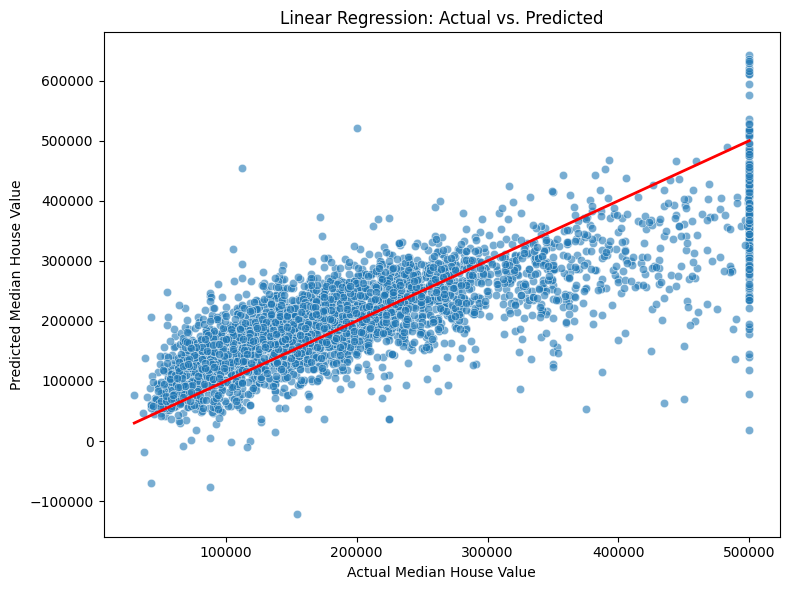

In [31]:
# Visualize Linear Regression predictions
pdf_predictions_lr = predictions_lr.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="label", y="prediction", data=pdf_predictions_lr, alpha=0.6)
plt.title("Linear Regression: Actual vs. Predicted")
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.plot([pdf_predictions_lr.label.min(), pdf_predictions_lr.label.max()],
         [pdf_predictions_lr.label.min(), pdf_predictions_lr.label.max()], color="red", lw=2)
plt.tight_layout()
plt.show()

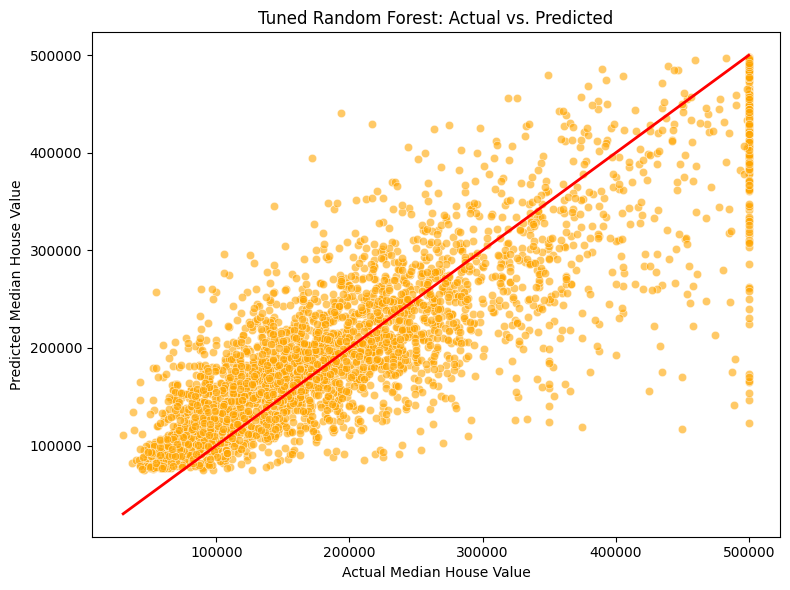

In [34]:
# Visualize Tuned Random Forest predictions
pdf_predictions_rf = predictions_cv_rf.select("label", "prediction").toPandas()  # Use predictions_cv_rf

plt.figure(figsize=(8, 6))
sns.scatterplot(x="label", y="prediction", data=pdf_predictions_rf, alpha=0.6, color='orange')
plt.title("Tuned Random Forest: Actual vs. Predicted")
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.plot([pdf_predictions_rf.label.min(), pdf_predictions_rf.label.max()],
         [pdf_predictions_rf.label.min(), pdf_predictions_rf.label.max()], color="red", lw=2)
plt.tight_layout()
plt.show()

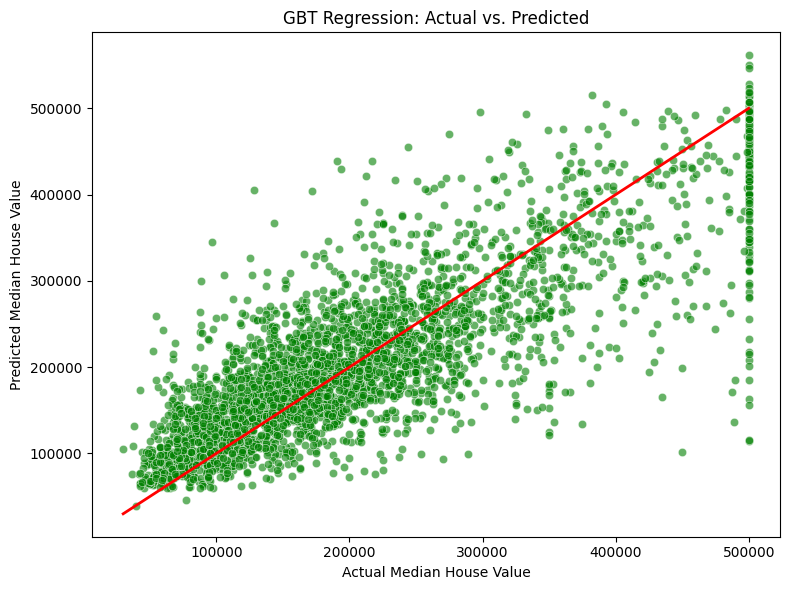

In [33]:
# Visualize GBT predictions
pdf_predictions_gbt = predictions_gbt.select("label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x="label", y="prediction", data=pdf_predictions_gbt, alpha=0.6, color='green')
plt.title("GBT Regression: Actual vs. Predicted")
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.plot([pdf_predictions_gbt.label.min(), pdf_predictions_gbt.label.max()],
         [pdf_predictions_gbt.label.min(), pdf_predictions_gbt.label.max()], color="red", lw=2)
plt.tight_layout()
plt.show()

# Conclusion

The notebook successfully demonstrates a complete and scalable workflow using PySpark for data exploration, feature engineering, and machine learning model development on the California Housing dataset. Key findings include:

- **Data Quality and Insights:**  
  The dataset is clean (with no missing values), and initial EDA reveals useful distributions and correlations among variables.
- **Feature Engineering Impact:**  
  The creation of new features (such as ratio variables, logarithmic transformations, and interaction terms) is vital for improving model performance.
- **Model Performance:**  
  Ensemble methods like Random Forest and GBT outperform the simple Linear Regression model, with the tuned Random Forest model achieving the best results (lower RMSE and higher R²).
- **Scalability:**  
  The use of PySpark ensures that the workflow can scale to large datasets, while also leveraging Python’s visualization libraries for insight generation.
  
 **Next Steps:**

 - Integrate additional models (e.g., XGBoost via Spark integration if needed).
 - Deploy the pipeline in a production environment.
 - Continue to refine feature engineering and tuning strategies.






---


---



---


---

